In [1]:
%pwd

'/Users/ryandevera/data-science/umn_environments/Deeplifting/deeplifting/notebooks'

In [2]:
%cd ../..

/Users/ryandevera/data-science/umn_environments/Deeplifting


In [3]:
%ls

README.md                      images/
__pycache__/                   jobs/
algorithm_compare_results/     models/
deeplifting/                   requirements.txt
deeplifting.png                results/
high-dimension-paper-results/  search_results/
high-dimension-search_results/ tasks.py


In [4]:
import glob as glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
file_directory = './algorithm_compare_results/low-dimensional/*/*'
files = glob.glob(file_directory)
files

['./algorithm_compare_results/low-dimensional/2023-09-14-12-cross_leg_table/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-12-levy_n13/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-12-cross_in_tray/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-12-holder_table/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-12-ackley/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-12-bukin_n6/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-12-griewank/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-12-rastrigin/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-12-levy/low-dimensional.parquet',
 './algorithm_compare_results/low-dimensional/2023-09-14-12-schaffer_n4/low-dimensional.parquet',
 './algorithm_compare_results/low-di

In [6]:
# Load in the data
data = pd.read_parquet(files)
data.head()

,x1,x2,f,algorithm,time,problem_name,hits,dimensions
0,0.964410,4.291258,-0.000054,IPOPT,2.595234,cross_leg_table,0,2
1,-9.947033,5.034317,-0.000070,IPOPT,2.395830,cross_leg_table,0,2
2,-1.100523,-8.526137,-0.000062,IPOPT,2.361027,cross_leg_table,0,2
3,1.005020,4.147946,-0.000054,IPOPT,2.594456,cross_leg_table,0,2
4,9.383436,0.926649,-0.000086,IPOPT,2.521434,cross_leg_table,0,2


In [7]:
data['algorithm'].unique()

array(['IPOPT', 'Dual Annealing', 'Differential Evolution', 'PyGRANSO',
       'SCIP'], dtype=object)

In [8]:
# Let's look at shubert
data.loc[data['problem_name'] == 'cross_leg_table']

,x1,x2,f,algorithm,time,problem_name,hits,dimensions
0,9.644101e-01,4.291258e+00,-0.000054,IPOPT,2.595234,cross_leg_table,0,2
1,-9.947033e+00,5.034317e+00,-0.000070,IPOPT,2.395830,cross_leg_table,0,2
2,-1.100523e+00,-8.526137e+00,-0.000062,IPOPT,2.361027,cross_leg_table,0,2
3,1.005020e+00,4.147946e+00,-0.000054,IPOPT,2.594456,cross_leg_table,0,2
4,9.383436e+00,9.266494e-01,-0.000086,IPOPT,2.521434,cross_leg_table,0,2
5,-5.569783e+00,7.377599e+00,-0.000064,IPOPT,2.458208,cross_leg_table,0,2
6,7.822983e+00,-3.190613e+00,-0.000080,IPOPT,2.670850,cross_leg_table,0,2
7,-8.432489e+00,5.609925e+00,-0.000067,IPOPT,2.378370,cross_leg_table,0,2
8,7.428862e+00,-9.992658e+00,-0.000072,IPOPT,2.312185,cross_leg_table,0,2
9,-9.788137e+00,-9.950957e+00,-0.000084,IPOPT,2.437401,cross_leg_table,0,2


In [9]:
aggregate_dict = {
    'hits': ['mean'],
}

# We want to group this data by
# problem name
# algorithm
# attributions are f, hits and time
results = data.groupby(['problem_name', 'algorithm', 'dimensions']).agg(aggregate_dict)

results.columns = ['-'.join(column) for column in results.columns]
results = results.rename(columns={'hits-mean': 'Success Rate'}).reset_index()
results['algorithm'] = np.where(
    results['algorithm'] == 'Differential Evolution', 'Diff. Evo.', results['algorithm']
)
results['algorithm'] = np.where(
    results['algorithm'] == 'Dual Annealing', 'Dual Anneal.', results['algorithm']
)
results

,problem_name,algorithm,dimensions,Success Rate
0,ackley,Diff. Evo.,2,1.0
1,ackley,Dual Anneal.,2,1.0
2,ackley,IPOPT,2,0.0
3,ackley,PyGRANSO,2,0.0
4,ackley,SCIP,2,1.0
...,...,...,...,...
70,shubert,Diff. Evo.,2,1.0
71,shubert,Dual Anneal.,2,1.0
72,shubert,IPOPT,2,0.1
73,shubert,PyGRANSO,2,0.2


In [10]:
# Let's try a heat map to look at all problems
hits_df = results.pivot_table(
    index='problem_name', columns='algorithm', values='Success Rate'
)

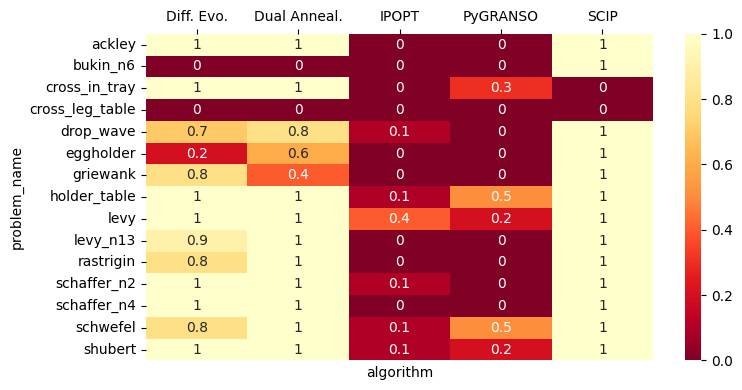

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,))
sns.heatmap(data=hits_df, annot=True, cmap='YlOrRd_r', ax=ax)
ax.xaxis.tick_top()

fig.tight_layout()